In [2]:
import numpy as np
import pandas as pd

import itertools

import torch
import torch.nn as nn
import torch.optim as optim

from hypll import nn as hnn
from hypll.tensors import TangentTensor
from hypll.optim import RiemannianAdam
from hypll.manifolds.poincare_ball import Curvature, PoincareBall

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [3]:
import sys
sys.path.append('../')
import util

In [4]:
TRAIN_FILE = '../data/tomato_samples_small.csv'
VAL_FILE = '../data/tomato_val_dataset.csv'

data = pd.read_csv(TRAIN_FILE, index_col=0)
val_data = pd.read_csv(VAL_FILE, index_col=0)

data

,Overall Liking,Texture liking,Sweetness,Sourness,Salty,Umami,Tomato Flavor Intenstity,glucose,fructose,Soluble solids,...,citric:malic,3-methyl-1-pentanol,2-ethylfuran,isopentyl acetate,cis-3-hexenyl acetate,benzothiazole,benzyl alcohol,citric acid,3-methyl-2-butenal,p-anisaldehyde
0,0.338117,0.340548,0.255690,0.179890,0.128725,0.126539,0.334159,2.295488,1.922709,2.609377,...,2.525383,1.004298,-0.955278,-0.553271,1.215329,0.406991,-0.317549,0.925334,-0.033387,0.608113
1,0.338558,0.341992,0.252528,0.181905,0.130022,0.130761,0.334679,2.289785,1.919508,2.578578,...,2.529219,1.112119,0.359303,-0.553271,1.187403,0.109232,0.152748,0.961596,-0.040644,0.294032
2,0.337087,0.340449,0.254016,0.180934,0.128220,0.129726,0.335890,2.289473,1.922699,2.573799,...,2.523873,1.172092,0.108147,-0.553271,1.213707,-0.001868,0.730046,0.968616,0.070380,0.206275
3,0.335989,0.340927,0.252928,0.179948,0.128490,0.128809,0.333764,2.292482,1.930334,2.548622,...,2.526806,1.106673,0.079866,-0.553271,1.299086,-0.474686,-0.022868,0.907907,-0.013365,-0.513916
4,0.337569,0.341524,0.255614,0.182741,0.129441,0.129830,0.334955,2.304824,1.923364,2.592205,...,2.523320,1.443889,-0.118773,-0.553271,1.268597,0.442448,-0.497099,0.927376,0.041410,-0.305158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
785,0.038452,0.015696,0.135181,0.084584,0.084834,0.096233,0.192040,-1.276013,-1.679005,-0.150519,...,-0.982699,-0.397338,-1.002327,-0.221668,-2.125245,0.144334,0.169158,-1.035213,-0.157703,1.396681
786,0.026240,0.024049,0.135422,0.090068,0.081171,0.095336,0.191894,-1.270116,-1.682095,-0.108075,...,-1.041210,-0.737587,-0.640720,-2.743479,-0.806120,0.506204,0.943026,-0.896349,-0.130640,-0.173906
787,0.029236,0.000000,0.134633,0.091357,0.082960,0.095025,0.189886,-1.294581,-1.686842,-0.063301,...,-1.039454,0.127056,0.661783,0.241626,-1.405112,-1.141838,0.499814,-0.966758,-0.470647,0.732512
788,0.037208,0.037641,0.133516,0.088080,0.081696,0.096633,0.192062,-1.287375,-1.678820,-0.082891,...,-1.039156,0.369953,-2.062269,1.195457,-1.379818,-0.401819,0.473431,-0.982592,-0.168658,1.120090


In [5]:
NUM_LABEL_COLS = 7
FEATURE_COLS = data.columns[NUM_LABEL_COLS:]
LABEL_COLS = data.columns[[0]]
print(FEATURE_COLS)
print(LABEL_COLS)

train_X = data[FEATURE_COLS].values
train_y = data[LABEL_COLS].values
val_X = val_data[FEATURE_COLS].values
val_y = val_data[LABEL_COLS].values

train_X.shape, train_y.shape, val_X.shape, val_y.shape

Index(['glucose', 'fructose', 'Soluble solids', '1-penten-3-one',
       'isovaleronitrile', 'trans-2-pentenal', 'trans-2-heptenal',
       'trans-3-hexen-1-ol', '6-methyl-5-hepten-2-ol', 'nonyl aldehyde',
       'cis-4-decenal', 'sugar:acid', 'isovaleraldehyde', '3-methyl-1-butanol',
       'methional', '2,5-dimethyl-4-hydroxy-3(2H)-furanone', '3-pentanone',
       '1-pentanol', 'benzyl cyanide', 'isovaleric acid', '2-isobutylthiazole',
       '1-nitro-3-methylbutane', 'benzaldehyde', '6-methyl-5-hepten-2-one',
       'b-ionone', 'b-cyclocitral', 'geranial', 'phenylacetaldehyde',
       'eugenol', 'geranylacetone', '2-phenyl ethanol', 'neral',
       'salicylaldehyde', 'isobutyl acetate', 'butyl acetate',
       'cis-3-hexen-1-ol', '1-nitro-2-phenylethane', '1-penten-3-ol',
       '2-methylbutyl acetate', 'heptaldehyde', 'trans,trans-2,4-decadienal',
       'malic acid', '2-methylbutanal', '4-carene', 'hexyl alcohol',
       'guaiacol', 'propyl acetate', 'hexanal', 'cis-2-penten-1-ol'

((790, 70), (790, 1), (79, 70), (79, 1))

In [6]:
FOLDS = 3
NUM_SAMPLE_TYPES = len(val_data)
NUM_SAMPLES_PER_TYPE = len(data) // NUM_SAMPLE_TYPES

fold_nums = list(range(FOLDS))
[num*NUM_SAMPLE_TYPES for num in fold_nums]
[(num+1)*NUM_SAMPLE_TYPES for num in fold_nums]


val_indices, train_indices = util.get_fold_indices_rand(NUM_SAMPLE_TYPES, NUM_SAMPLES_PER_TYPE, FOLDS)
train_indices
# print(FOLD_INDICES)

[array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,
         82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,
         95,  96,  97,  98,  99, 110, 111, 112, 113, 114, 115, 116, 117,
        118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 160,
        161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173,
        174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186,
        187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199,
        200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 220, 221, 222,
        223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235,
        236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248,
        249, 250, 251, 252, 253, 254, 255, 256, 257

In [17]:
[np.sort(val_i) for val_i in val_indices]

[array([ 4,  5,  6, 10, 13, 14, 15, 21, 26, 29, 31, 32, 37, 40, 42, 44, 49,
        56, 57, 58, 61, 64, 66, 68, 71, 72, 77], dtype=int64),
 array([ 0,  3,  8, 16, 17, 18, 19, 20, 22, 23, 24, 27, 28, 30, 36, 39, 41,
        46, 47, 48, 54, 59, 60, 63, 65, 78], dtype=int64),
 array([ 1,  2,  7,  9, 11, 12, 25, 33, 34, 35, 38, 43, 45, 50, 51, 52, 53,
        55, 62, 67, 69, 70, 73, 74, 75, 76], dtype=int64)]

In [7]:
# Define custom PyTorch dataset
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

<h1> Hyperbolic </h1>

In [8]:
# Define your MLP model
class HYP_MLP(nn.Module):
    def __init__(self, input_size, output_size, layer_size, num_hidden_layers, manifold):
        super(HYP_MLP, self).__init__()
        torch.manual_seed(42)
        self.fc_in = hnn.HLinear(input_size, layer_size, manifold=manifold)
        self.relu = hnn.HReLU(manifold=manifold)
        self.hidden_fcs = nn.ModuleList([hnn.HLinear(layer_size, layer_size, manifold=manifold) for _ in range(num_hidden_layers)])
        self.fc_out = hnn.HLinear(layer_size, output_size, manifold=manifold)

    def forward(self, x):
        x = self.fc_in(x)
        x = self.relu(x)
        for fc in self.hidden_fcs:
            x = fc(x)
            x = self.relu(x)
        x = self.fc_out(x)

        return x


# Define training function
def hyp_train_model(model, train_loader, criterion, optimizer, manifold, device):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        tangents = TangentTensor(data=inputs, man_dim=-1, manifold=manifold)
        manifold_inputs = manifold.expmap(tangents)

        outputs = model(manifold_inputs)

        loss = criterion(outputs.tensor, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    return running_loss / len(train_loader.dataset)

<h1> EUCLIDEAN </h1>

In [9]:
# Define your MLP model
class EUC_MLP(nn.Module):
    def __init__(self, input_size, output_size, layer_size, num_hidden_layers):
        super(EUC_MLP, self).__init__()
        torch.manual_seed(42)
        self.fc_in = nn.Linear(input_size, layer_size)
        self.relu = nn.ReLU()
        self.hidden_fcs = nn.ModuleList([nn.Linear(layer_size, layer_size) for _ in range(num_hidden_layers)])
        self.fc_out = nn.Linear(layer_size, output_size)

    def forward(self, x):
        x = self.fc_in(x)
        x = self.relu(x)
        for fc in self.hidden_fcs:
            x = fc(x)
            x = self.relu(x)
        x = self.fc_out(x)

        return x

# Define training function
def euc_train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    return running_loss / len(train_loader.dataset)

In [21]:
param_grid = {
    'model_type': ['hyp', 'euc'],
    'num_hidden_layers': [1,2,4,8],
    'layer_size': [16,32,48,64,96,128],
    'lr': [0.02],
    'weight_decay': [0.003,0.004,0.005],
    'batch_size': [1024],
    'epochs': [100],
    'curvature': [-1]
}

param_combinations = list(itertools.product(*param_grid.values()))
len(param_combinations)

144

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

param_eval_stats = []

for i, params in enumerate(param_combinations):
    print(f'----- Combination {i} -----')
    print(*zip(param_grid.keys(), params))
    model_type, num_hidden_layers, layer_size, lr, weight_decay, batch_size, epochs, curvature = params
    for fold, (fold_train_indices, fold_val_indices) in enumerate(zip(train_indices, val_indices)):
        print(f'Fold {fold}')

        fold_train_X = train_X[fold_train_indices]
        fold_train_y = train_y[fold_train_indices]
        fold_val_X   = val_X[fold_val_indices]
        fold_val_y   = val_y[fold_val_indices]

        train_dataset = CustomDataset(fold_train_X, fold_train_y)
        val_dataset = CustomDataset(fold_val_X, fold_val_y)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)

        if model_type == 'hyp':
            manifold = PoincareBall(c=Curvature(curvature))
        elif model_type == 'euc':
            manifold = None

        if model_type == 'hyp':
            model = HYP_MLP(input_size=len(FEATURE_COLS),
                            output_size=len(LABEL_COLS),
                            layer_size=layer_size,
                            num_hidden_layers=num_hidden_layers,
                            manifold=manifold).to(device)
        elif model_type == 'euc':
            model = EUC_MLP(input_size=len(FEATURE_COLS),
                            output_size=len(LABEL_COLS),
                            layer_size=layer_size,
                            num_hidden_layers=num_hidden_layers).to(device)

        criterion = nn.MSELoss()

        if model_type == 'hyp':
            optimizer = RiemannianAdam(model.parameters(), lr=lr, weight_decay=weight_decay)
        elif model_type == 'euc':
            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

        eval_stats = {'loss': {'train': [], 'val': []}, 'mae': {'train': [], 'val': []}}

        for epoch in range(epochs):
            if model_type == 'hyp':
                eval_stats['loss']['train'].append(hyp_train_model(model, train_loader, criterion, optimizer, manifold, device))
                eval_stats['loss']['val'].append(util.h_evaluate_loss(model, val_loader, criterion, manifold, device))

                eval_stats['mae']['train'].append(util.h_evaluate_mae(model, train_loader, manifold, device))
                eval_stats['mae']['val'].append(util.h_evaluate_mae(model, val_loader, manifold, device))
            elif model_type == 'euc':
                eval_stats['loss']['train'].append(euc_train_model(model, train_loader, criterion, optimizer, device))
                eval_stats['loss']['val'].append(util.evaluate_loss(model, val_loader, criterion, device))

                eval_stats['mae']['train'].append(util.evaluate_mae(model, train_loader, device))
                eval_stats['mae']['val'].append(util.evaluate_mae(model, val_loader, device))

        print(eval_stats['mae']['val'])
        param_eval_stats.append(eval_stats)

----- Combination 0 -----
('model_type', 'hyp') ('num_hidden_layers', 1) ('layer_size', 16) ('lr', 0.02) ('weight_decay', 0.003) ('batch_size', 1024) ('epochs', 100) ('curvature', -1)
Fold 0
[0.3911045, 0.32768166, 0.28975633, 0.26571205, 0.25085375, 0.24413326, 0.21605848, 0.16990338, 0.14686504, 0.14181502, 0.12857041, 0.11469315, 0.10950137, 0.10794987, 0.108243845, 0.107114464, 0.10427984, 0.094851986, 0.08213126, 0.07222062, 0.06473697, 0.05929878, 0.05680106, 0.056869287, 0.05752203, 0.05643594, 0.054239538, 0.051426098, 0.051150814, 0.053178985, 0.05736274, 0.06136813, 0.0634997, 0.063587055, 0.0616698, 0.058596738, 0.054679923, 0.05085859, 0.04791085, 0.04721389, 0.047220062, 0.047476936, 0.04764163, 0.047716476, 0.047979493, 0.04904296, 0.050164446, 0.051315594, 0.052304592, 0.052693132, 0.05253353, 0.051925853, 0.0510349, 0.050234012, 0.049532447, 0.048919946, 0.0484691, 0.048258282, 0.048226666, 0.048272416, 0.048322245, 0.04847276, 0.048627272, 0.048964307, 0.04930386, 0.04

In [ ]:
values = [s['mae']['val'] for s in param_eval_stats]

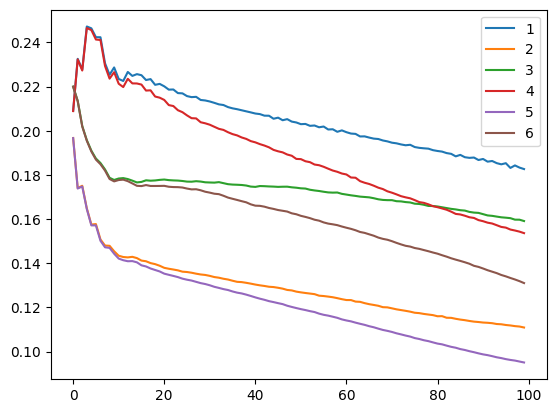

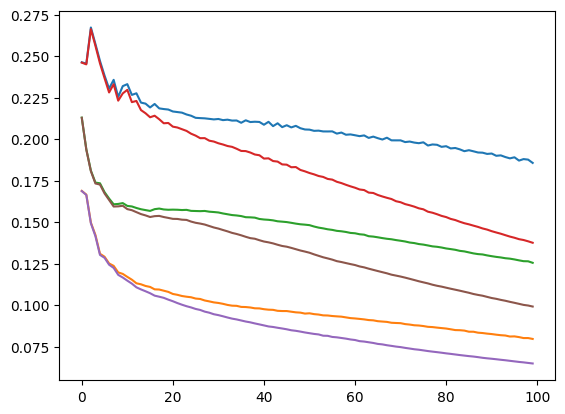

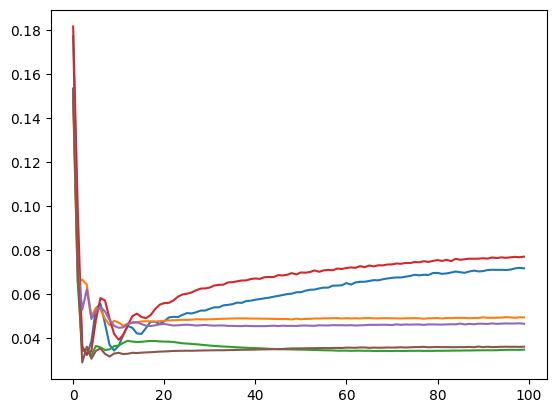

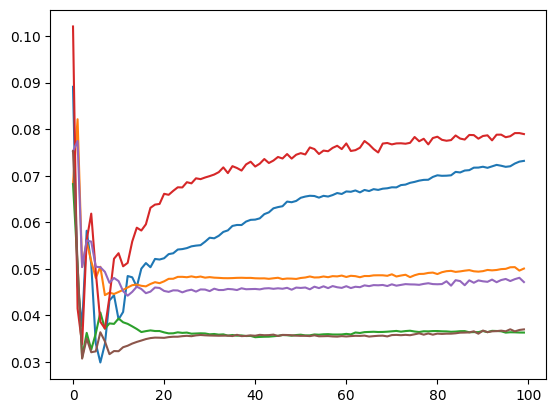

In [ ]:
import matplotlib.pyplot as plt

plt.plot(np.array(values[:12][:6]).T)
plt.legend([1,2,3,4,5,6])
plt.show()
plt.plot(np.array(values[:12][6:]).T)
plt.show()
plt.plot(np.array(values[12:][:6]).T)
plt.show()
plt.plot(np.array(values[12:][6:]).T)
plt.show()